# Importy

In [1]:
! pip install bitsandbytes==0.43.1 accelerate==0.27.2 datasets==2.19.2 diffusers==0.26.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB

In [2]:
import gc
import os
import shutil
from pathlib import Path
from dataclasses import dataclass
from typing import List
import bitsandbytes as bnb
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, CLIPTextModel

from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    StableDiffusionControlNetPipeline,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)

logger = get_logger(__name__)

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
# ! gdown https://drive.google.com/uc?id=13qdTt3C90Daf6Uz7jDMvYdMLJnoU2LM4
# ! gdown https://drive.google.com/uc?id=1DAJhg1_g-__rg-DLyP3psSPc0lcbc9Dx
! gdown https://drive.google.com/uc?id=1GxfKG5RdkV17K4c6aY4SxgmrOtnQzB_m
! unzip imgs.zip
! unzip data.zip
! unzip ckpt.zip

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1GxfKG5RdkV17K4c6aY4SxgmrOtnQzB_m

but Gdown can't. Please check connections and permissions.
Archive:  imgs.zip
replace imgs/example_output.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  data.zip
replace data/conditioning_image_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: unzip:  cannot find or open ckpt.zip, ckpt.zip.zip or ckpt.zip.ZIP.


# Wstęp
Duże modele dyfuzyjne text-to-image, takie jak Stable Diffusion, są trenowane do generowania obrazów na podstawie tekstowych opisów podanych przez użytkownika. Jednak czasami chcemy uzyskać bardziej szczegółowe rezultaty z określoną strukturą np. z zadanymi konturami. Niestety UNet, stosowany w modelach dyfuzyjnych, nie ma bezpośredniej możliwości uwzględnienia dodatkowych informacji warunkujących podczas generowania.

W tym celu powstał ControlNet - model, który umożliwia dodanie dodatkowych informacji warunkujących do wytrenowanego wcześniej modelu dyfuzyjnego. ControlNet pozwala na wykorzystanie graficznej reprezentacji obrazu, jak kontury, mapy segmentacji, mapy głębi czy pozycji ciała, w procesie generowania. Model ten został zaprojektowany tak, aby tworzyć obrazy spełniające podane warunki, niezmieniając jednak parametrów oryginalnego modelu dyfuzjnego.

In [ ]:
Image.open('imgs/controlnet_usecase.png')

Output hidden; open in https://colab.research.google.com to view.

ControlNet polega na skopiowaniu enkodera UNetu z modelu dyfuzyjnego, wraz z wartościami wag. Mapy cech oryginalnego enkodera i ControlNetu są ze sobą sumowane i przekazywane do dekodera. W trakcie treningu optymalizujemy jedynie parametry controlnetu, a parametry oryginalnego UNetu pozostają nienaruszone.

Kluczowym elementem ControlNetu jest zastosowanie konwolucji zainicjowanej zerami (zero convolution) na wejściu i wyjściu ControlNetu. Zapobiega to gwałtownym zmianom w mapach cech oryginalnego UNetu. W pierwszej iteracji ControlNet działa jak standardowy UNet, a w kolejnych iteracjach wagi zerowych konwolucji stopniowo się zmieniają, co pozwala mu powoli dostosowywać się do warunkowanych obrazów.

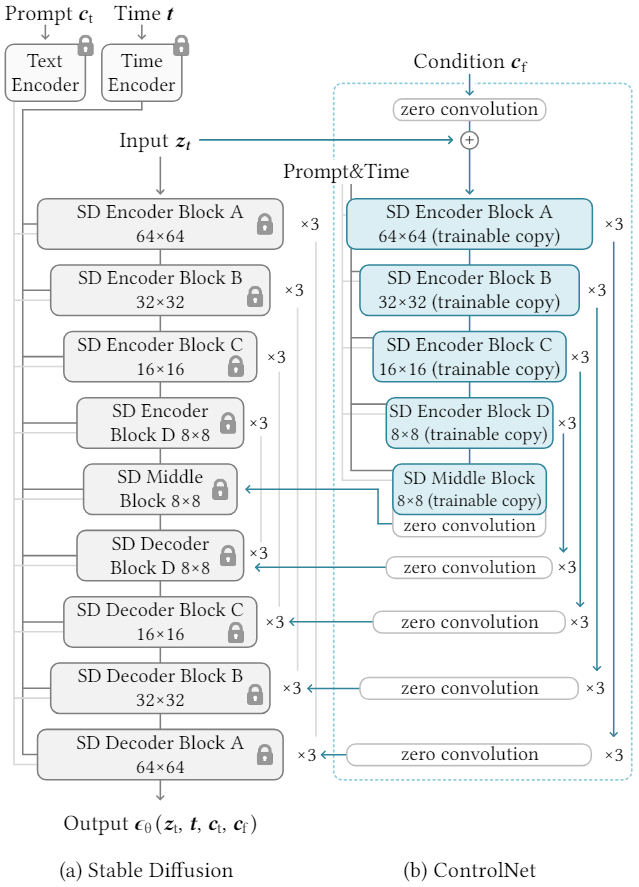

In [ ]:
Image.open('imgs/controlnet_diagram.png')

Aby zobrazować działanie metody ControlNet, przeprowadzimy trening modelu opartego na modelu Stable Diffusion na zadaniu generowania kolorowych kółek. W tym przypadku informacje o kolorach będą pochodzić z promptu tekstowego, natomiast informacje o lokalizacji i rozmiarze kół będą pochodzić z wejściowych obrazów ControlNetu, przedstawiających kontury oczekiwanych kółek.

W folderze `data` znajdują się dwa przykładowe kontury kółek, które zostaną użyte do walidacji modelu. Te przykładowe kontury pozwolą nam sprawdzić, czy model poprawnie generuje kolorowe kółka zgodnie z podanymi wytycznymi dotyczącymi ich lokalizacji i rozmiaru. Dzięki temu będziemy mogli ocenić, jak dobrze ControlNet radzi sobie z przekształcaniem dodatkowych informacji graficznych na szczegółowe i zgodne z oczekiwaniami obrazy.

Przykładowe wyniki powinny wyglądać następująco (zwróć uwagę na stosowny prompt w tytule):

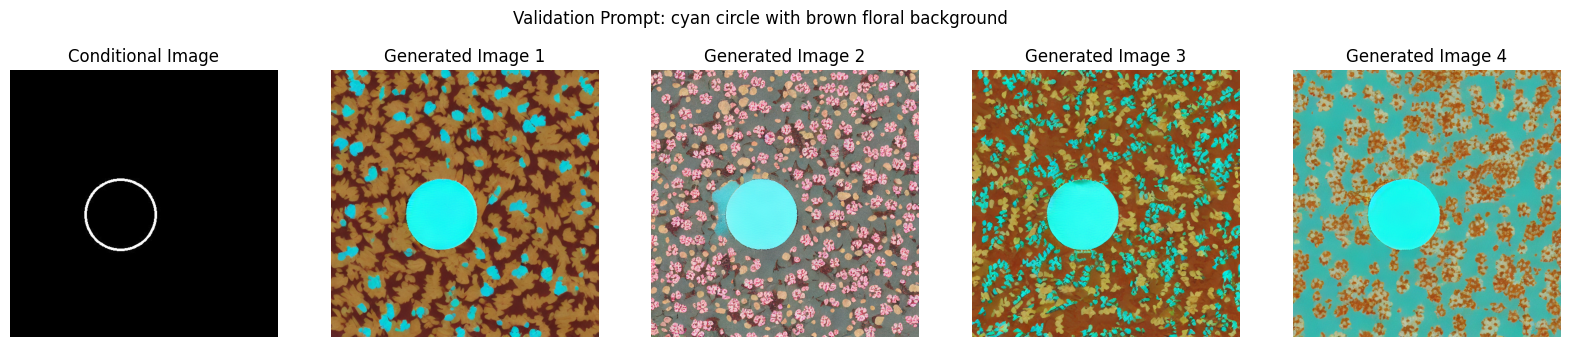

In [ ]:
Image.open('imgs/example_output.png')

# Kod

## Dataset
Poniższa komórka implementuje zbiór danych Fill50K z portalu HuggingFace. Zbiór ten zawiera 50 tysięcy przykładów, gdzie każdy przykład zawiera tekst, obrazek oraz kontur obrazka.

In [ ]:
class Fill50kDataset:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

        self.image_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]), # This normalize image to range -1, 1
        ])

        self.cond_image_transforms = transforms.ToTensor()

        self.dataset = load_dataset('fusing/fill50k', trust_remote_code=True)['train'].with_transform(self.preprocess_train)

    def tokenize_captions(self, examples):
        return self.tokenizer(
            examples['text'], max_length=self.tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        ).input_ids

    def preprocess_train(self, examples):
        examples["ground_truth"] = [self.image_transforms(image.convert("RGB")) for image in examples['image']]
        examples["cond_image"] = [self.cond_image_transforms(image.convert("RGB")) for image in examples['conditioning_image']]
        examples["input_ids"] = self.tokenize_captions(examples)

        return examples

    def collate_fn(self, examples):
        x_0 = torch.stack([example["ground_truth"] for example in examples])
        x_0 = x_0.to(memory_format=torch.contiguous_format).float()

        cond_image = torch.stack([example["cond_image"] for example in examples])
        cond_image = cond_image.to(memory_format=torch.contiguous_format).float()

        input_ids = torch.stack([example["input_ids"] for example in examples])

        return {
            "ground_truth": x_0,
            "cond_image": cond_image,
            "input_ids": input_ids,
        }

    def __call__(self):
        return self.dataset

    def __len__(self):
        return len(self.dataset)

    def dataloader(self, batch_size, shuffle=True):
        return torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=self.collate_fn)

## Funkcja treningowa
Poniższa komórka zawiera funkcję odpowiedzialną za proces uczenia ControlNetu. Linijki podzielone są na sekcje, które odpowiadają za:

1. Najpierw, obrazek kolorowych kółek jest osadzany (embeddowany) w przestrzeni ukrytej (latent space) modelu dyfuzyjnego z wykorzystaniem enkodera z VAE. Embeddingi/latenty te oznaczamy jako $x_0$.

2. Losujemy szum z rozkładu normalnego $\epsilon \sim N(0, \mathbb{I})$, który później dodamy do embeddingów.

3. Losujemy dyskretny czas dyfuzyjny $t$ z przedziału $[0, T]$. Wartości $t$ odpowiadają za ilość szumu nałożonego na oryginalny latent $x_0$.

4. Zgodnie ze wzorem forward diffusion process, wyznaczamy zaszumioną reprezentację ukrytą $x_t$. Wartości $\bar{\alpha}_t$ są wyznaczane na podstawie wybranego noise schedulera:
$$ x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon $$

5. Przy wykorzystaniu modelu CLIP, obliczamy embeddingi dla tekstu, które zostaną użyte do warunkowania modelu dyfuzyjnego:
$$z_{\text{text}} = \text{CLIP}(\text{prompt})$$

6. Obraz z konturami kółek (nasz obrazek warunkujący) jest przetwarzany przez model ControlNet (patrz na schemat z początku notatnika). Generuje on mapy cech $z_{\text{control}}$ na różnych poziomach rozdzielczości. Zostaną one zsumowane z mapami cech enkodera oryginalnego UNetu:
$$ z_{\text{control}} = \text{ControlNet}(x_{\text{contour}}, t, z_{\text{text}}) $$

7. Zaszumiona reprezentacja obrazu kółek trafia do oryginalnego UNeu. Wartości z map cech ControlNetu są sumowane z wartościami z map cech enkodera UNetu. UNet przewiduje szum $\epsilon$, który był zaaplikowany do początkowych embeddingów $x_0$:
$$ \epsilon_{\text{pred}} = \text{UNet}(x_t, z_{\text{control}}, t, z_{\text{text}}) $$

8. Na podstawie wyniku modelu $\epsilon_{\text{pred}}$ oraz rzeczywistego szumu $\epsilon$ obliczamy błąd średniokwadratowy (MSE):
$$ L = || \epsilon_{\text{pred}} - \epsilon ||_2^2 $$

In [ ]:
def train_step(
            vae,
            unet,
            controlnet,
            text_encoder,
            noise_scheduler,
            batch,
            weight_dtype
        ):
    # 1) Convert images to latent space
    latents = vae.encode(batch["ground_truth"].to(dtype=weight_dtype)).latent_dist.sample()
    latents = latents * vae.config.scaling_factor

    # 2) Sample noise that we'll add to the latents
    noise = torch.randn_like(latents)

    # 3) Sample a random timestep for each image
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()

    # 4) Add noise to the latents according to the noise magnitude at each timestep
    # (this is the forward diffusion process)
    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

    # 5) Get the text embedding for conditioning
    encoder_hidden_states = text_encoder(batch["input_ids"], return_dict=False)[0]

    # 6) controlnet pass
    controlnet_image = batch["cond_image"].to(dtype=weight_dtype)

    down_block_res_samples, mid_block_res_sample = controlnet(
        noisy_latents,
        timesteps,
        encoder_hidden_states=encoder_hidden_states,
        controlnet_cond=controlnet_image,
        return_dict=False,
    )

    # 7) Predict the noise residual with original UNet. Use Controlnet outputs to modify UNet feature maps
    model_pred, = unet(
        noisy_latents,
        timesteps,
        encoder_hidden_states=encoder_hidden_states,
        down_block_additional_residuals=[
            sample.to(dtype=weight_dtype) for sample in down_block_res_samples
        ],
        mid_block_additional_residual=mid_block_res_sample.to(dtype=weight_dtype),
        return_dict=False,
    )

    # 8) calculate the loss (Mean Square Error) between model predictions and applied noise
    loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

    return loss

## Funkcja walidacyjna
Poniższa komórka zawiera kod do wizualnej walidacji ControlNetu. Walidacja wykonywana jest co określoną liczbę kroków w trakcie treningu (domyślnie co 200 kroków).
Funkcje:
- `plot_controlnet_results` - wyświetla kilka przykładowych wyników controlnetu dla podanego tekstu i konturu. Kontur rysowany jest po lewej stronie.
- `log_validation` - tworzy pipeline controlnetu i dla każdej pary tekstu i konturu tworzy `samples_per_prompt` wyników i wywołuje funkcję `plot_controlnet_results` do ich wizualizacji.
- `save_checkpoints` - usuwa poprzedni checkpoint i zapisuje nowy checkpoint controlnetu.
- `validation_step` - główna funkcja walidacji - wywołuje funkcję `log_validation` oraz `save_checkpoint`.

In [ ]:
def plot_controlnet_results(images, validation_prompt):
    _, ax = plt.subplots(1, len(images), figsize=(20, 4))

    ax[0].imshow(images[0])
    ax[0].axis("off")
    ax[0].set_title("Conditional Image")

    for i in range(1, len(images)):
        ax[i].imshow(images[i])
        ax[i].axis("off")
        ax[i].set_title(f"Generated Image {i}")

    plt.suptitle(f"Validation Prompt: {validation_prompt}")
    plt.show()


def log_validation(
    vae, text_encoder, tokenizer, unet, controlnet, args, accelerator, weight_dtype, samples_per_prompt=4
):
    controlnet = accelerator.unwrap_model(controlnet)

    pipeline = StableDiffusionControlNetPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        unet=unet,
        controlnet=controlnet,
        safety_checker=None,
        requires_safety_checker=False,
        torch_dtype=weight_dtype,
    )
    pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    for validation_prompt, validation_image in zip(args.validation_prompt, args.validation_image):
        validation_image = Image.open(validation_image).convert("RGB")

        images = [validation_image]

        for _ in range(samples_per_prompt):
            with torch.autocast('cuda'):
                images.append(pipeline(
                    validation_prompt, validation_image, num_inference_steps=20
                ).images[0])

        plot_controlnet_results(images, validation_prompt)

    del pipeline
    gc.collect()
    torch.cuda.empty_cache()


def save_checkpoint(args, global_step, accelerator):
    checkpoints = os.listdir(args.output_dir)
    checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]

    for removing_checkpoint in checkpoints:
        removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
        shutil.rmtree(removing_checkpoint)

    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
    accelerator.save_state(save_path)


def validation_step(
    vae,
    text_encoder,
    tokenizer,
    unet,
    controlnet,
    args,
    accelerator,
    weight_dtype,
    global_step
):
    log_validation(
        vae,
        text_encoder,
        tokenizer,
        unet,
        controlnet,
        args,
        accelerator,
        weight_dtype
    )

    save_checkpoint(args, global_step, accelerator)

## Config
Poniższe dwie komórki zawierają domyślne wartości parametrów eksperymentu. Liczba możliwości jest mocno ograniczona w celu zapewnienia klarowności kodu.

In [ ]:
@dataclass
class Arguments:
    pretrained_model_name_or_path: str = None
    output_dir: str = None
    dataset_name: str = None
    validation_image: List[str] = None
    validation_prompt: List[str] = None

    learning_rate: float = 1e-4
    use_8bit_adam: bool = True
    max_grad_norm: float = 1.0

    train_batch_size: int = 8
    validation_interval: int = 200
    num_train_epochs: int = 1

In [ ]:
args = Arguments(
    pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5",
    output_dir = "./output_dir",
    dataset_name = "fusing/fill50k",
    validation_image = ["./data/conditioning_image_1.png", "./data/conditioning_image_2.png"],
    validation_prompt = ["red circle with blue background", "cyan circle with brown floral background"],
)

## Inicjalizacja
Poniższa grupa komórek zawiera inicjalizację wszystkich komponentów użytych do trenowania modelu ControlNet.
Ustawienie ziarna losowości, inicjalizacja obiektu trenującego (`Accelerator`) oraz stworzenie potrzebnych folderów

In [ ]:
set_seed(42)

logging_dir = Path("logs")

accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

accelerator = Accelerator(
    mixed_precision="fp16",
    project_config=accelerator_project_config,
)

if args.output_dir is not None:
    os.makedirs(args.output_dir, exist_ok=True)

Inizjalizacja:
- `tokenizer` - używany do zmiany prompta na tokeny, które będą używane przez model CLIP
- `noise_scheduler` - harmonogram szumu, który określa jak dużo szumu ma być nałożone na obrazek w danym kroku dyfuzyjnym
- `text_encoder` - model CLIP do generowania osadzeń tekstu, które służą do warunkowania procesu generatywnego
- `vae` - do osadzania obrazków w przestrzeni ukrytej, na której bazuje model dyfuzyjny
- `unet` - używany do rekonstrukcji obrazów zaszumionych (a dokładniej - zaszumionych osadzeń VAE)
- `controlnet` - używany do warunkowania modelu dyfuzyjnego na podstawie konturów obrazków. Inicjalizowany jest wagami enkodera UNetu

Warto zwrócić uwagę, że `vae`, `unet` oraz `text_encoder` są zamrożone, co oznacza, że ich wagi nie będą aktualizowane w trakcie treningu, natomiast `controlnet` jest trenowany i jego parametry trafiają do optymalizatora.

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    args.pretrained_model_name_or_path,
    subfolder="tokenizer",
    use_fast=False,
)

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
text_encoder = CLIPTextModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet"
)

controlnet = ControlNetModel.from_unet(unet)

vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder.requires_grad_(False)
controlnet.train()


# Optimizer creation
optimizer = bnb.optim.AdamW8bit(
    controlnet.parameters(),
    lr=args.learning_rate,
) # `torch.optim.AdamW` if you don't want to use 8-bit quantization for AdamW

print("Done loading models")

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Done loading models


Inicjalizacja dataloadera Fill50K. Przygotowanie modeli i danych do trenowania i kwantyzacja modeli do 16 bitów.

In [ ]:
train_dataset = Fill50kDataset(tokenizer)

train_dataloader = train_dataset.dataloader(args.train_batch_size, shuffle=True)

# Prepare everything with our `accelerator`.
controlnet, optimizer, train_dataloader = accelerator.prepare(
    controlnet, optimizer, train_dataloader
)

weight_dtype = torch.float16

# Move vae, unet and text_encoder to device and cast to weight_dtype
vae.to(accelerator.device, dtype=weight_dtype)
unet.to(accelerator.device, dtype=weight_dtype)
text_encoder.to(accelerator.device, dtype=weight_dtype)

print("Done preparing models and data")

Done preparing models and data


Przed przystąpieniem do treningu modelu ControlNet, zobaczmy jak wyglądają przykładowe dane ze zbioru `Fill50K`.

Rozmiar zbioru danych: 50000
Rozdzielczość docelowego obrazka: (512, 512)
Ilość kanałów w docelowym obrazku: 3
Rozdzielczość warunkującego obrazka: (512, 512)
Ilość kanałów w warunkującym obrazku: 3


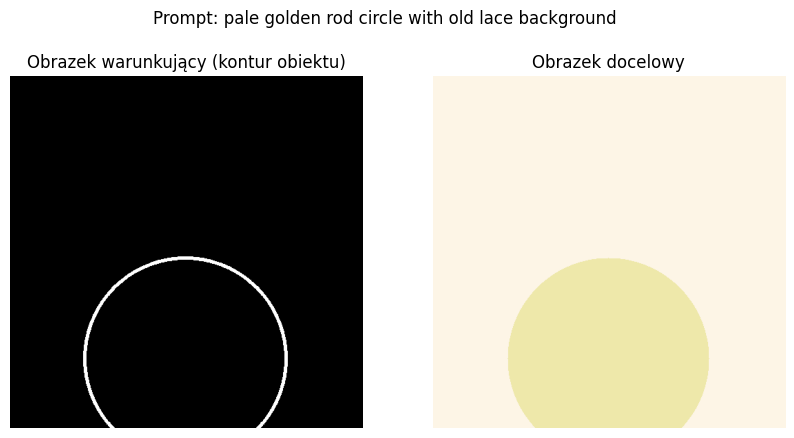

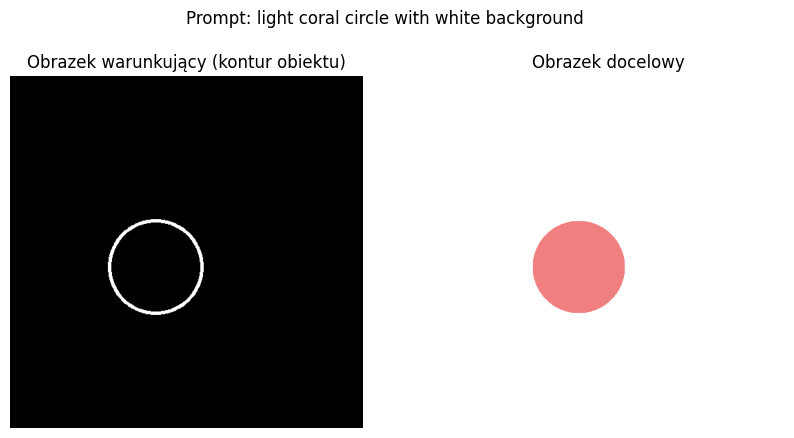

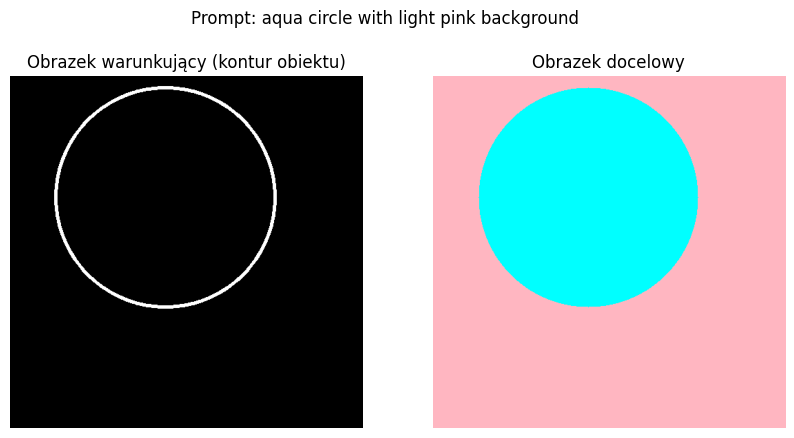

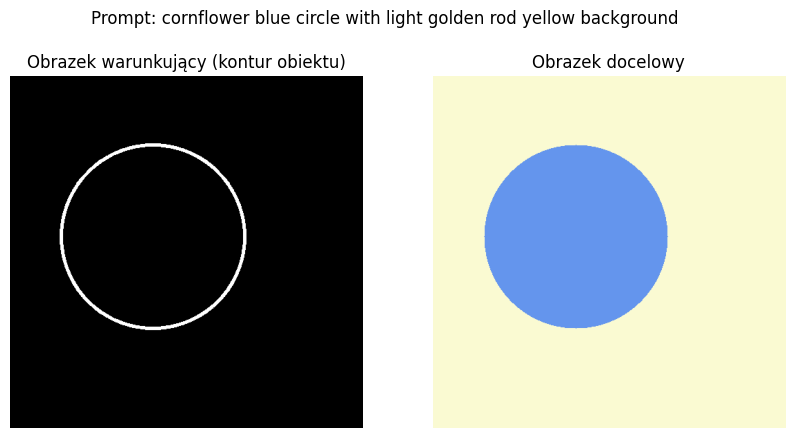

In [ ]:
print('Rozmiar zbioru danych:', len(train_dataset))

sample = train_dataset.dataset[0]
image = sample['image']
conditioning_image = sample['conditioning_image']
text = sample['text']

print('Rozdzielczość docelowego obrazka:', image.size)
print('Liczba kanałów w docelowym obrazku:', len(image.getbands()))

print('Rozdzielczość warunkującego obrazka:', conditioning_image.size)
print('Liczba kanałów w warunkującym obrazku:', len(conditioning_image.getbands()))

# matplotlib show the image and conditioning image in subplot
for i in range(4):
    sample = train_dataset.dataset[i]
    image = sample['image']
    conditioning_image = sample['conditioning_image']
    text = sample['text']

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(conditioning_image)
    ax[0].axis('off')
    ax[0].set_title('Obrazek warunkujący (kontur obiektu)')

    ax[1].imshow(image)
    ax[1].axis('off')
    ax[1].set_title('Obrazek docelowy')

    plt.suptitle('Prompt: ' + text)
    plt.show()



Jak widać, kontury pokrywają się z umiejscowieniem kółek na obrazkach docelowych. Takiej informacji nie bylibyśmy w stanie efektywnie wprowadzić przy pomocy samego promptu tekstowego. Właśnie dlatego ControlNet jest tak przydatny w tego typu zadaniach.

## Trening

In [ ]:
logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num batches each epoch = {len(train_dataloader)}")
logger.info(f"  Num Epochs = {args.num_train_epochs}")
logger.info(f"  Batch size = {args.train_batch_size}")
logger.info(f"  Total optimization steps = {len(train_dataloader) * args.num_train_epochs}")

global_step = 0
first_epoch = 0

progress_bar = tqdm(
    enumerate(train_dataloader),
    initial=0,
    desc="Steps",
    total=len(train_dataloader),
)

for epoch in range(args.num_train_epochs):
    for step, batch in progress_bar:
        loss = train_step(
            vae,
            unet,
            controlnet,
            text_encoder,
            noise_scheduler,
            batch,
            weight_dtype
        )

        accelerator.backward(loss)
        accelerator.clip_grad_norm_(controlnet.parameters(), args.max_grad_norm)
        optimizer.step()
        optimizer.zero_grad()

        global_step += 1

        # validate and save the checkpoint
        if global_step % args.validation_interval == 0:
            validation_step(
                vae=vae,
                text_encoder=text_encoder,
                tokenizer=tokenizer,
                unet=unet,
                controlnet=controlnet,
                args=args,
                accelerator=accelerator,
                weight_dtype=weight_dtype,
                global_step=global_step
            )

        progress_bar.set_postfix(loss=loss.detach().item())



## Walidacja z ckpt

Wczytanie modelu i walidacja. Pamiętaj o wcześniejszej inicjalizacji obiektów modelu i danych.

In [ ]:
accelerator.load_state('ckpt')

Napiszmy jakie kolory kółka oraz tła chcielibyśmy uzyskać.

In [ ]:
args.validation_prompt = ["brown circle with green floral background"]

In [ ]:
validation_step(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    controlnet=controlnet,
    args=args,
    accelerator=accelerator,
    weight_dtype=weight_dtype,
    global_step=6000
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

RuntimeError: mat1 and mat2 must have the same dtype, but got Half and Float